<a href="https://colab.research.google.com/github/nudojacopo/Conversation_dynamics/blob/main/src/SYN/focus/Saturaion_with_N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Load the data
fb = pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
rd = pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')
vo = pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')
gb = pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')

## Prepare Data

In [3]:

h=100 # number of hours considered
# List of DataFrames to process
dfs = [rd, vo, gb, fb]

# Define a function to apply the required transformations
def process_df(df):
    df = filter_first_h(df, h)  # Assuming filter_first_h is a function you have defined
    df['year'] = pd.to_datetime(df['thread_birth']).dt.year
    df['thread_birth'] = pd.to_datetime(df['thread_birth'], errors='coerce')

    # Check for NaT values
    if df['thread_birth'].isnull().any():
        print("There are NaT values in 'thread_birth' after conversion.")

    # Create the 'month-year' column
    df['month-year'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d')
    df['unique_users'] = df.groupby('month-year')['user_id'].transform('nunique')

    # Group by and rename columns
    df = df.groupby(['unique_users', 'post_id'])['user_id'].nunique().reset_index()
    df.columns = ['N', 'post_id', 'n_c']

    return df

# Process each DataFrame and collect the results
processed_dfs = [process_df(df) for df in dfs]

# Concatenate all processed DataFrames
df_combined = pd.concat(processed_dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df_combined.head())


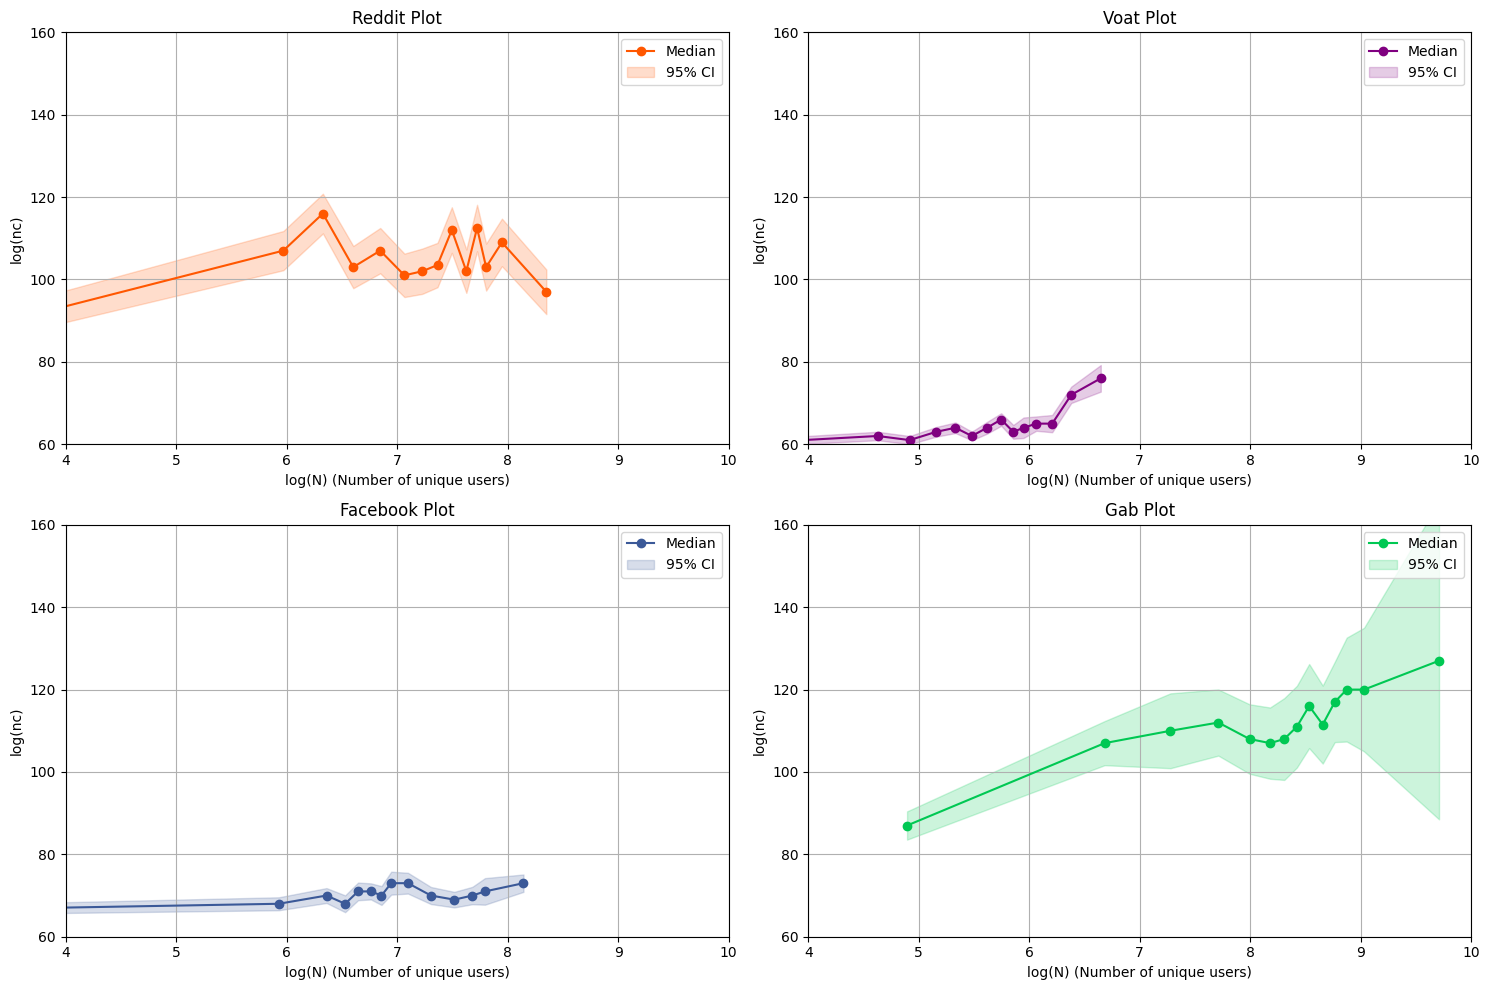

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the color palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Assume dfs = [rd, vo, gb, fb] are your dataframes corresponding to the platforms
# And these are the names of the platforms
platform_names = ['Reddit', 'Voat', 'Facebook', 'Gab']

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration

# Define a function to apply the required transformations
def process_df(df, platform_name):
    df = filter_first_h(df, h)  # Assuming filter_first_h is a function you have defined
    df['year'] = pd.to_datetime(df['thread_birth']).dt.year
    df['thread_birth'] = pd.to_datetime(df['thread_birth'], errors='coerce')

    # Check for NaT values
    if df['thread_birth'].isnull().any():
        print(f"There are NaT values in 'thread_birth' after conversion for {platform_name}.")

    # Create the 'month-year' column
    df['month-year'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d')
    df['unique_users'] = df.groupby('month-year')['user_id'].transform('nunique')

    # Group by and rename columns
    df = df.groupby(['unique_users', 'post_id'])['comment_id'].count().reset_index()
    df.columns = ['N', 'post_id', 'n_c']
    df = df[df['n_c'] > 50]
    df['log_N'] = np.log(df['N'])  # Use base-10 logarithm
    df['log_nc'] = df['n_c']

    # Create bins based on quantiles
    quantiles = np.linspace(0, 1, 15)  # 20 bins
    bins = df['log_N'].quantile(quantiles).values  # Get bin edges based on quantiles
    df['bin'] = pd.cut(df['log_N'], bins=bins)

    # Calculate median and confidence intervals of log_nc for each bin
    bin_stats = df.groupby('bin')['log_nc'].agg(['median', 'std', 'count']).reset_index()
    bin_edges = pd.IntervalIndex(df['bin'].cat.categories).mid.values

    # Calculate the 95% confidence intervals
    # We use the formula for the confidence interval of the median: median ± 1.96 * (std / sqrt(count))
    z_value = 1.28  # Critical value for 80% confidence
    bin_stats['ci_lower'] = bin_stats['median'] - z_value * (bin_stats['std'] / np.sqrt(bin_stats['count']))
    bin_stats['ci_upper'] = bin_stats['median'] + z_value * (bin_stats['std'] / np.sqrt(bin_stats['count']))

    return bin_edges, bin_stats

# Iterate over each DataFrame and its corresponding axis
for ax, df, platform_name in zip(axes, dfs, platform_names):
    bin_edges, bin_stats = process_df(df, platform_name)

    # Plotting
    ax.plot(bin_edges, bin_stats['median'], marker='o', linestyle='-', color=palette[platform_name], label='Median')
    ax.fill_between(bin_edges, bin_stats['ci_lower'], bin_stats['ci_upper'], color=palette[platform_name], alpha=0.2, label='95% CI')
    ax.set_title(f'{platform_name} Plot')
    ax.set_xlabel('log(N) (Number of unique users)')
    ax.set_ylabel('log(nc)')
    ax.set_xlim(4, 10)
    ax.set_ylim(60, 160)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


<ipython-input-58-c5a72f6e73b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_N'] = (df['N'])  # Use base-10 logarithm
<ipython-input-58-c5a72f6e73b5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_nc'] = df['n_c']
<ipython-input-58-c5a72f6e73b5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

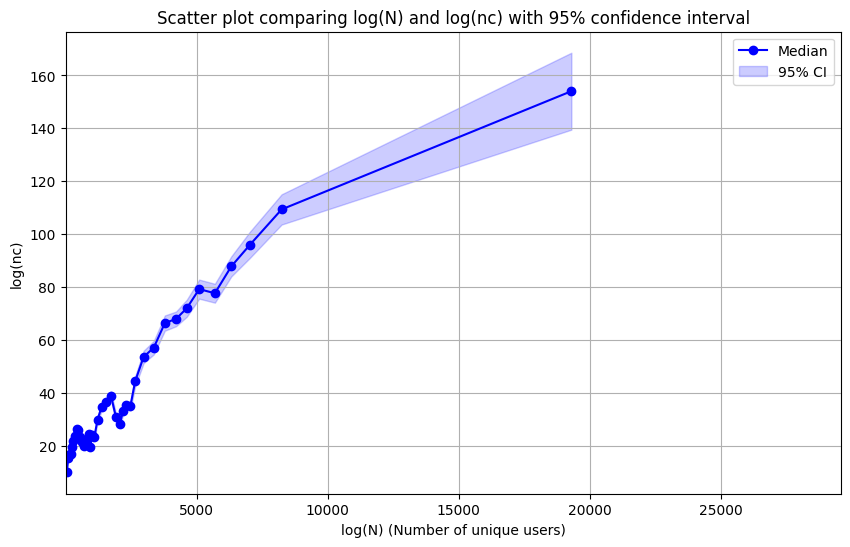

In [58]:
df=df_combined[df_combined['N']>10]

df['log_N'] = (df['N'])  # Use base-10 logarithm
df['log_nc'] = df['n_c']

# Create bins based on quantiles
quantiles = np.linspace(0, 1, 40)  # 20 bins
bins = df['log_N'].quantile(quantiles).values  # Get bin edges based on quantiles
df['bin'] = pd.cut(df['log_N'], bins=bins)

# Calculate median and confidence intervals of log_nc for each bin
bin_stats = df.groupby('bin')['log_nc'].agg(['mean', 'std', 'count']).reset_index()
bin_edges = pd.IntervalIndex(df['bin'].cat.categories).mid.values

# Calculate the 95% confidence intervals
# We use the formula for the confidence interval of the median: median ± 1.96 * (std / sqrt(count))
bin_stats['ci_lower'] = bin_stats['mean'] - 1.28 * (bin_stats['std'] / np.sqrt(bin_stats['count']))
bin_stats['ci_upper'] = bin_stats['mean'] + 1.28 * (bin_stats['std'] / np.sqrt(bin_stats['count']))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_edges, bin_stats['mean'], marker='o', linestyle='-', color='b', label='Median')
plt.fill_between(bin_edges, bin_stats['ci_lower'], bin_stats['ci_upper'], color='b', alpha=0.2, label='95% CI')
plt.plot(bin_edges2, bin_stats2['mean'], marker='o', linestyle='-', color='b', label='Median')
plt.fill_between(bin_edges2, bin_stats2['ci_lower'], bin_stats['ci_upper'], color='b', alpha=0.2, label='95% CI')
plt.title('Scatter plot comparing log(N) and log(nc) with 95% confidence interval')
plt.xlabel('log(N) (Number of unique users)')
plt.ylabel('log(nc)')
plt.xlim(df['log_N'].min(), df['log_N'].max())
plt.grid(True)
plt.legend()
plt.show()

nc vs nu

In [172]:
import pandas as pd

# Supponendo che filter_first_h sia una funzione definita che filtra il dataframe fb
df = filter_first_h(rd, h)

# Conversione della colonna 'thread_birth' in datetime
df['thread_birth'] = pd.to_datetime(df['thread_birth'], errors='coerce')

# Controllo per valori NaT in 'thread_birth'
if df['thread_birth'].isnull().any():
    print("Ci sono valori NaT in 'thread_birth' dopo la conversione.")

# Creazione della colonna 'year' e 'month-year'
df['year'] = pd.to_datetime(df['thread_birth']).dt.year
df['month-year'] = pd.to_datetime(df['created_at']).dt.to_period('Q')

# Conteggio degli utenti unici per 'month-year'
df['N'] = df.groupby(['month-year','topic'])['user_id'].transform('nunique')
df['nc'] = df.groupby('post_id')['comment_id'].transform('count')
df['nu'] = df.groupby('post_id')['user_id'].transform('nunique')


<ipython-input-172-12a918527d73>:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month-year'] = pd.to_datetime(df['created_at']).dt.to_period('Q')


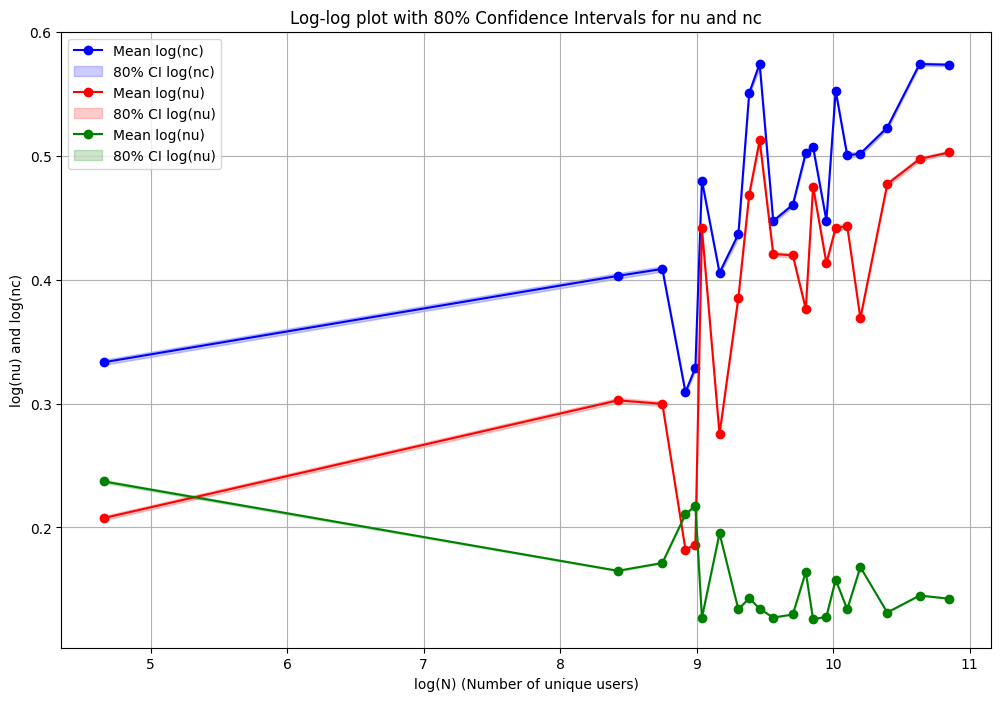

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded with the columns 'N', 'nu', and 'nc'
df = df[['N', 'nu', 'nc']]
df = df[df['N']>1 ]

# Use base-10 logarithm for log_N, log_nc, and log_nu
df['log_N'] =np.log(df['N'])
df['log_nc'] = (df['nc'])/max((df['nc']))
df['log_nu'] =(df['nu'])/max((df['nu']))
df['log_ncu']=(df['log_nc']/df['log_nu'])/max(df['log_nc']/df['log_nu'])

# Create bins based on quantiles
quantiles = np.linspace(0, 1, 30)  # 20 bins
bins = df['log_N'].quantile(quantiles).values
df['bin'] = pd.cut(df['log_N'], bins=bins, include_lowest=True, duplicates='drop')

# Calculate mean and confidence intervals for log_nc
bin_stats_nc = df.groupby('bin')['log_nc'].agg(['mean', 'std', 'count']).reset_index()
bin_edges_nc = pd.IntervalIndex(df['bin'].cat.categories).mid.values

# Calculate the 80% confidence intervals for log_nc
z_value = 1.98  # Critical value for 80% confidence
bin_stats_nc['ci_lower'] = bin_stats_nc['mean'] - z_value * (bin_stats_nc['std'] / np.sqrt(bin_stats_nc['count']))
bin_stats_nc['ci_upper'] = bin_stats_nc['mean'] + z_value * (bin_stats_nc['std'] / np.sqrt(bin_stats_nc['count']))

# Calculate mean and confidence intervals for log_nu
bin_stats_nu = df.groupby('bin')['log_nu'].agg(['mean', 'std', 'count']).reset_index()
bin_edges_nu = pd.IntervalIndex(df['bin'].cat.categories).mid.values

# Calculate the 80% confidence intervals for log_nu
bin_stats_nu['ci_lower'] = bin_stats_nu['mean'] - z_value * (bin_stats_nu['std'] / np.sqrt(bin_stats_nu['count']))
bin_stats_nu['ci_upper'] = bin_stats_nu['mean'] + z_value * (bin_stats_nu['std'] / np.sqrt(bin_stats_nu['count']))


bin_stats_ncu = df.groupby('bin')['log_ncu'].agg(['mean', 'std', 'count']).reset_index()
bin_edges_ncu = pd.IntervalIndex(df['bin'].cat.categories).mid.values

# Calculate the 80% confidence intervals for log_nc
z_value = 1.98  # Critical value for 80% confidence
bin_stats_ncu['ci_lower'] = bin_stats_ncu['mean'] - z_value * (bin_stats_ncu['std'] / np.sqrt(bin_stats_ncu['count']))
bin_stats_ncu['ci_upper'] = bin_stats_ncu['mean'] + z_value * (bin_stats_ncu['std'] / np.sqrt(bin_stats_ncu['count']))

# Plotting
plt.figure(figsize=(12, 8))

# Plot for log_nc
plt.plot(bin_edges_nc, bin_stats_nc['mean'], marker='o', linestyle='-', color='b', label='Mean log(nc)')
plt.fill_between(bin_edges_nc, bin_stats_nc['ci_lower'], bin_stats_nc['ci_upper'], color='b', alpha=0.2, label='80% CI log(nc)')

# Plot for log_nu
plt.plot(bin_edges_nu, bin_stats_nu['mean'], marker='o', linestyle='-', color='r', label='Mean log(nu)')
plt.fill_between(bin_edges_nu, bin_stats_nu['ci_lower'], bin_stats_nu['ci_upper'], color='r', alpha=0.2, label='80% CI log(nu)')

# Plot for log_nu
plt.plot(bin_edges_ncu, bin_stats_ncu['mean'], marker='o', linestyle='-', color='g', label='Mean log(nu)')
plt.fill_between(bin_edges_ncu, bin_stats_ncu['ci_lower'], bin_stats_ncu['ci_upper'], color='g', alpha=0.2, label='80% CI log(nu)')

plt.title('Log-log plot with 80% Confidence Intervals for nu and nc')
plt.xlabel('log(N) (Number of unique users)')
plt.ylabel('log(nu) and log(nc)')
plt.grid(True)
plt.legend()
plt.show()


nu vs nc

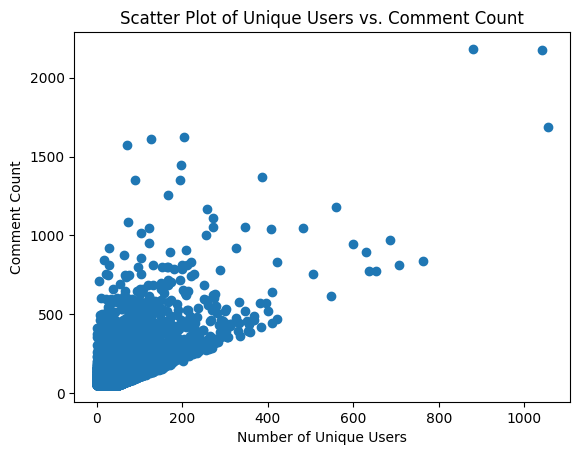

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


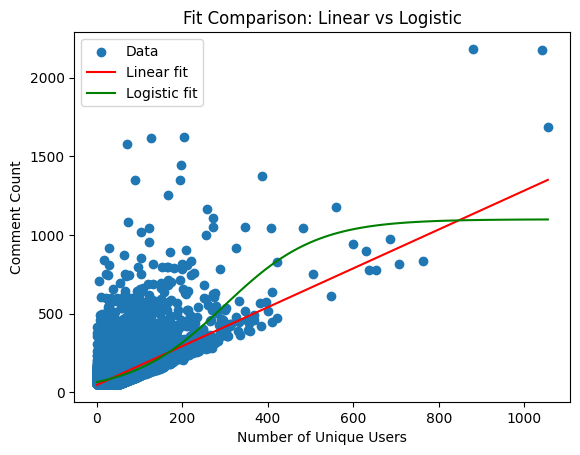

Linear fit AIC: 193834.41, BIC: 193850.50
Logistic fit AIC: 192973.79, BIC: 192997.93


In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Step 1: Create the series
nu = rd.groupby('post_id')['user_id'].unique()
nc = rd.groupby('post_id')['comment_id'].count()

# Step 2: Convert series to DataFrame
nu_df = nu.apply(len).reset_index(name='unique_users')  # Counting unique users
nc_df = nc.reset_index(name='comment_count')

# Step 3: Merge DataFrames on 'post_id'
merged_df = pd.merge(nu_df, nc_df, on='post_id')

# Step 4: Create scatter plot
plt.scatter(merged_df['unique_users'], merged_df['comment_count'])
plt.xlabel('Number of Unique Users')
plt.ylabel('Comment Count')
plt.title('Scatter Plot of Unique Users vs. Comment Count')
plt.show()

# Step 5: Fit linear model
def linear_model(x, a, b):
    return a * x + b

popt_linear, pcov_linear = curve_fit(linear_model, merged_df['unique_users'], merged_df['comment_count'])

# Step 6: Fit logistic model
def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

popt_logistic, pcov_logistic = curve_fit(logistic_model, merged_df['unique_users'], merged_df['comment_count'], p0=[max(merged_df['comment_count']), 1, np.median(merged_df['unique_users'])])

# Step 7: Calculate AIC and BIC for each model
def calculate_aic(y, y_pred, num_params):
    resid = y - y_pred
    ss_resid = np.sum(resid**2)
    n = len(y)
    aic = n * np.log(ss_resid / n) + 2 * num_params
    return aic

def calculate_bic(y, y_pred, num_params):
    resid = y - y_pred
    ss_resid = np.sum(resid**2)
    n = len(y)
    bic = n * np.log(ss_resid / n) + num_params * np.log(n)
    return bic

# Predictions
y_pred_linear = linear_model(merged_df['unique_users'], *popt_linear)
y_pred_logistic = logistic_model(merged_df['unique_users'], *popt_logistic)

# Calculate AIC and BIC
aic_linear = calculate_aic(merged_df['comment_count'], y_pred_linear, len(popt_linear))
bic_linear = calculate_bic(merged_df['comment_count'], y_pred_linear, len(popt_linear))
aic_logistic = calculate_aic(merged_df['comment_count'], y_pred_logistic, len(popt_logistic))
bic_logistic = calculate_bic(merged_df['comment_count'], y_pred_logistic, len(popt_logistic))

# Step 8: Visualize fit and compare models
x_values = np.linspace(min(merged_df['unique_users']), max(merged_df['unique_users']), 100)

plt.scatter(merged_df['unique_users'], merged_df['comment_count'], label='Data')
plt.plot(x_values, linear_model(x_values, *popt_linear), label='Linear fit', color='red')
plt.plot(x_values, logistic_model(x_values, *popt_logistic), label='Logistic fit', color='green')
plt.xlabel('Number of Unique Users')
plt.ylabel('Comment Count')
plt.title('Fit Comparison: Linear vs Logistic')
plt.legend()
plt.show()

# Print AIC and BIC
print("Linear fit AIC: {:.2f}, BIC: {:.2f}".format(aic_linear, bic_linear))
print("Logistic fit AIC: {:.2f}, BIC: {:.2f}".format(aic_logistic, bic_logistic))


Alpha vs Audience

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the color palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Lista dei DataFrame e dei titoli dei grafici
dfs = [rd, vo, gb, fb]
titles = ['Reddit', 'Voat', 'Gab', 'Facebook']

# Configura la figura e gli assi per il layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()  # Facilita l'accesso agli assi


for idx, df in enumerate(dfs):
    h = 1000  # Definisci il valore corretto di h
    df = filter_first_h(dfs[idx], h)

    # Controllo per valori NaT in 'thread_birth'
    df['month-year'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d')

    # Conteggio degli utenti unici per 'month-year'
    df['N'] = df.groupby(['month-year', 'topic'])['user_id'].transform('nunique')
    alpha = df.groupby(['post_id', 'user_id', 'N'])['comment_id'].count().reset_index()
    alpha['N']=np.log(alpha['N'])
    bins = np.arange(4, 15.5, 0.5)  # Nota: 10.5 per includere l'ultimo valore 10

    # Applica pd.cut per assegnare i dati ai bin definiti
    alpha['N_binned'] = pd.cut(alpha['N'], bins=bins, include_lowest=True)
    # Calculate summary statistics
    summary = alpha.groupby('N_binned')['comment_id'].agg(['mean', 'count', 'std'])
    summary['ci'] = 1.96 * (summary['std'] / np.sqrt(summary['count']))  # 95% confidence interval

    # Convert intervals to strings for plotting
    summary.reset_index(inplace=True)
    summary['N_binned_str'] = summary['N_binned'].astype(str)

    # Plotting
    axs[idx].plot(summary['N_binned_str'], summary['mean'], marker='o', linestyle='-', color=palette[titles[idx]])
    axs[idx].fill_between(summary['N_binned_str'],
                          summary['mean'] - summary['ci'],
                          summary['mean'] + summary['ci'],
                          color=palette[titles[idx]], alpha=0.2, label='95% CI')
    axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)
    axs[idx].set_title(titles[idx])
    axs[idx].set_xlabel('N (quantile-based bins)')
    axs[idx].set_ylabel('comment_id')
    axs[idx].set_xlim(4,11)
    axs[idx].set_ylim(0.5,5)
    axs[idx].grid(True)
    axs[idx].legend()

# Aggiungi un layout migliore per i sottotitoli e la figura
plt.tight_layout()
plt.show()


<ipython-input-28-a1ce761d3065>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)
<ipython-input-28-a1ce761d3065>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)


In [26]:
alpha['N'].max()

12.325183687884076